In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors, Crippen, Fingerprints
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap

In [55]:
# Read in data from RI dataset
ri_data = pd.read_csv("ri_dataset.csv", index_col=0)
ri_data

,Name,Cas No.,solubility,predicted pH,RI,smiles,mols,mw,exactmw,amw,...,kappa1,kappa2,kappa3,Phi,single,double,molar_conc_low,ri,molar_conc_high,molar_conc
0,"Dipotassium Anthraquinone-1,8-disulfonate",14938-42-2,-,5.633900,1.3335,[K+].[K+].[O-][S](=O)(=O)c1cccc2C(=O)c3cccc(c3...,<rdkit.Chem.rdchem.Mol object at 0x7fcf3a7ddd60>,444.524,443.877823,444.524,...,24.909940,8.708168,4.382474,8.343075,14,6,0.224960,1.333500,2,0.224960
1,5-Amino-1-pentanol,2508-29-4,+,12.526278,1.3463,[NH3+]CCCCCO,<rdkit.Chem.rdchem.Mol object at 0x7fcf3a7ddf20>,104.173,104.106990,104.173,...,6.920000,5.920000,5.920000,5.852343,20,0,0.959942,1.346300,2,0.959942
2,(2-Amino-4-thiazolyl)acetic Acid,29676-71-9,-,5.877254,1.3490,Nc1scc(CC(O)=O)n1,<rdkit.Chem.rdchem.Mol object at 0x7fcf3a7dde40>,158.182,158.014998,158.182,...,7.012360,2.656020,1.696130,1.862497,10,1,0.632183,1.349000,2,0.632183
3,4-Amino-1-butanol,13325-10-5,+,12.263965,1.3442,[NH3+]CCCCO,<rdkit.Chem.rdchem.Mol object at 0x7fcf3a7ddeb0>,90.146,90.091340,90.146,...,5.920000,4.920000,3.920000,4.854400,17,0,1.109312,1.344200,2,1.109312
4,6-Amino-1-hexanol,4048-33-3,+,11.939876,1.3458,NCCCCCCO,<rdkit.Chem.rdchem.Mol object at 0x7fceec1c95f0>,117.192,117.115364,117.192,...,7.920000,6.920000,5.920000,6.850800,22,0,0.853301,1.345800,2,0.853301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855,NaOH,1310-73-2,+,7.289101,1.3569,[OH-].[Na+],<rdkit.Chem.rdchem.Mol object at 0x7fceec2116d0>,39.997,39.992509,39.997,...,12.338472,1.960000,0.001667,12.091703,1,0,2.500188,1.417813,2,12.500938
2856,NaCl,7647-14-5,+,6.109838,1.3502,[Na+].[Cl-],<rdkit.Chem.rdchem.Mol object at 0x7fceec211740>,58.443,57.958622,58.443,...,10.367820,2.290000,0.065194,11.871154,0,0,1.711069,1.416024,2,8.555345
2857,Urea,57-13-6,+,7.533970,1.3469,NC(N)=O,<rdkit.Chem.rdchem.Mol object at 0x7fceec2117b0>,60.056,60.032363,60.056,...,3.270000,0.710529,0.173734,0.580857,6,1,1.665113,1.405138,2,8.325563
2858,Sucrose,57-50-1,+,6.481410,1.3472,OC[C@H]1O[C@H](O[C@]2(CO)O[C@H](CO)[C@@H](O)[C...,<rdkit.Chem.rdchem.Mol object at 0x7fceec211820>,342.297,342.116212,342.297,...,18.892352,7.207281,3.226802,5.920109,46,0,0.292144,1.400031,2,1.460720


In [56]:
# Split the RI dataset into training and testing sets
# 70% of the data is used for training, 30% is used for testing

X = ri_data.iloc[:, np.r_[7:53, 56]]    # Features - physicochemical properties
y = ri_data["ri"]   # Target - refractive index

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### XGBoost Regressor ###

In [57]:
# Initialize XGBoost regressor model for refractive index prediction
xgb_model = xgb.XGBRegressor()

# Fit the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

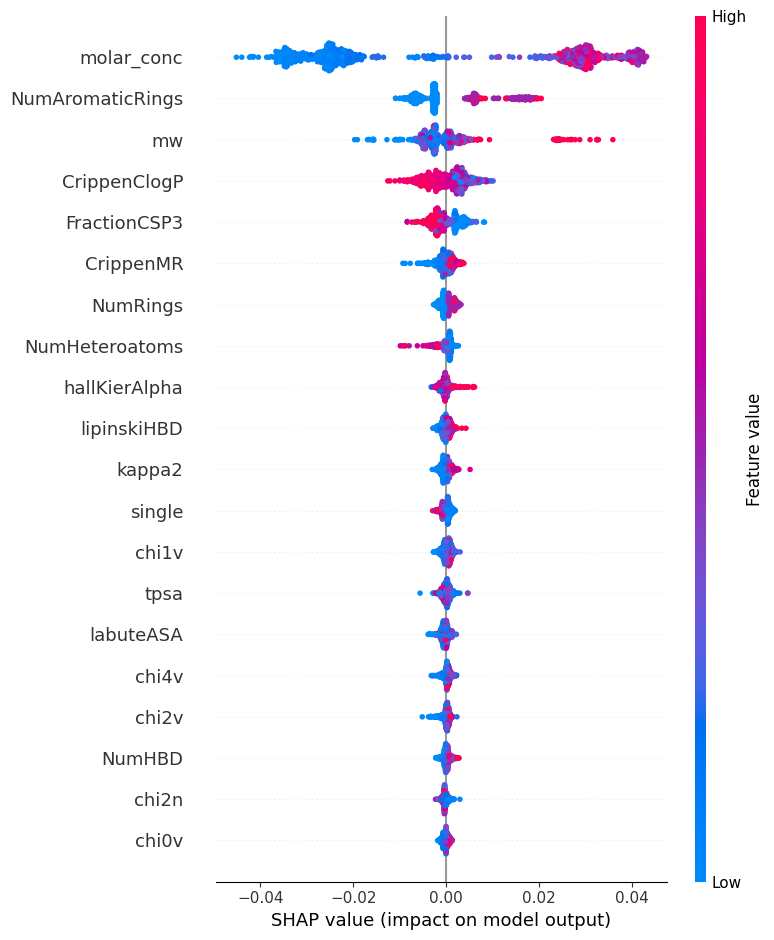

In [58]:
# Using SHAP values to select the most important features for the XGBoost model
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Show summary plot with shap values of each feature in the dataset
shap.summary_plot(shap_values, X_test)

In [59]:
# Filter out selected SHAP features (features having the strongest impacts on prediction)
 
X_selected = ri_data[["molar_conc", "NumAromaticRings", "CrippenClogP", "FractionCSP3", "mw", "NumRings", "CrippenMR", 
                      "hallKierAlpha", "NumHeteroatoms", "chi1v", "single", "labuteASA", "tpsa", "NumHBD", "chi2v", 
                      "chi4v", "kappa3", "Phi", "kappa2", "chi0n"]]

In [60]:
# Perform train test split again with only selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.3, random_state = 42)

Hyperparameter tuning

In [122]:
from sklearn.model_selection import GridSearchCV
# Hyperparameter tuning - learning rate and n estimators

# Define params grid
param_grid = {
    "learning_rate": np.arange(0.01, 0.1, 0.01),
    "n_estimators": range(100, 1000, 100),
}

# Initialize model
model = xgb.XGBRegressor()

# Grid search to find the best parameters
grid_search = GridSearchCV(model, 
                           param_grid = param_grid, 
                           cv = 3, 
                           scoring = "neg_mean_squared_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                         'n_estimators': range(100, 1000, 100)},
             scoring='neg_mean_squared_error')

In [ ]:
# Get best params and use in next round of tuning
grid_search.best_params_

{'learning_rate': 0.08, 'n_estimators': 300}

In [ ]:
# Hyperparameter tuning - max depth and min child weight

# Define params grid
param_grid = {
    "max_depth": range(1, 11),
    "min_child_weight": range(1, 11)
}

# Create model
model = xgb.XGBRegressor(learning_rate = 0.08, 
                         n_estimators = 300)

# Grid search
grid_search = GridSearchCV(model, 
                           param_grid = param_grid, 
                           cv = 3, 
                           scoring = "neg_mean_squared_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.08, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=300,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'max_depth': range(1, 11),
                         'min_child_weight': range(1, 11)},
             scoring='neg_mean_squared_error')

In [ ]:
# Get best params and use in next round of tuning
grid_search.best_params_

{'max_depth': 4, 'min_child_weight': 5}

In [ ]:
# Hyperparameter tuning - subsample

# Define params grid
param_grid = {
    "subsample": np.arange(0.1, 0.9, 0.1)
}

# Create model
model = xgb.XGBRegressor(learning_rate = 0.08, 
                         n_estimators = 300,
                         max_depth = 4,
                         min_child_weight = 5)

# Grid search
grid_search = GridSearchCV(model, 
                           param_grid = param_grid, 
                           cv = 3, 
                           scoring = "neg_mean_squared_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.08, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=4, max_leaves=None,
                                    min_child_weight=5, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=300,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])},
             scoring='neg_mean_squared_error')

In [ ]:
### Get best params and use in next round of tuning
grid_search.best_params_

{'subsample': 0.7000000000000001}

In [ ]:
# Hyperparameter tuning - reg_lambda

# Define params grid
param_grid = {
    "reg_lambda": np.arange(0.1, 2, 0.1)
}

# Create model
model = xgb.XGBRegressor(learning_rate = 0.08, 
                         n_estimators = 300,
                         max_depth = 4,
                         min_child_weight = 5,
                         subsample = 0.7)

# Grid search
grid_search = GridSearchCV(model, 
                           param_grid = param_grid, 
                           cv = 3, 
                           scoring = "neg_mean_squared_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=4, max_leaves=None,
                                    min_child_weight=5, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=300,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'reg_lambda': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])},
             scoring='neg_mean_squared_error')

In [ ]:
# Get best params
grid_search.best_params_

{'reg_lambda': 1.2000000000000002}

Prediction Model

In [ ]:
# Build model using best params
# Note - some parameters are slightly adjusted from the grid search results to minimize errors and maximize R^2

best_params = {
    "learning_rate": 0.09,
    "n_estimators": 300,
    "max_depth": 5,
    "min_child_weight": 7,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "reg_lambda": 1.6,
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
}

# Grid search
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Make predictions
pred = final_model.predict(X_test)

# Get MSE
mse = mean_squared_error(y_test, pred)

# Get r2 score
r2 = r2_score(y_test, pred)

# Get std
res = y_test - pred
std = np.std(res)

# Print results
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))
print("R^2 score: ", r2)
print("std: ", std)

MSE:  4.2020121729731256e-05
RMSE:  0.0064822929376672925
R^2 score:  0.9687852323076759
std:  0.006479947546557563


In [ ]:
# Average percentage error of predictions from XGBoost Regressor model
mean_ri = np.mean(y)
pct_error = (np.sqrt(mse) / mean_ri) * 100
print(f"Percentage error using mean squared error: {pct_error:.3f}%")

Percentage error using mean squared error: 0.471%


Perform 10-fold cross validation

In [ ]:
# Training R² (how well the model fits the training data)
y_train_pred = final_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)

# Cross-validation R² 
cv_scores = cross_val_score(final_model, X_train, y_train, cv=10, scoring='r2')
r2_cv_mean = cv_scores.mean()

# Test R² (how well the model generalizes to new unseen data)
y_test_pred = final_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"Training R²: {r2_train:.4f}")
print(f"Cross-Validation R²: {r2_cv_mean:.4f}")
print(f"Test R²: {r2_test:.4f}")

Training R²: 0.9945
Cross-Validation R²: 0.9557
Test R²: 0.9688


/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

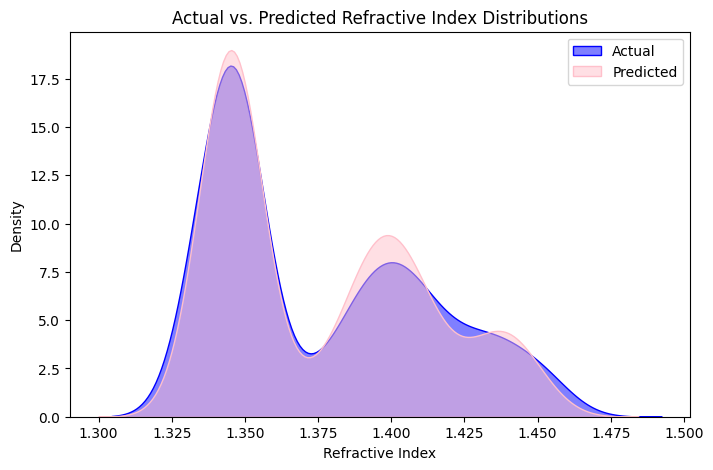

In [ ]:
# Visualize model's performance
# Plot the actual and predicted refractive index distributions
plt.figure(figsize=(8,5))

# sns.kdeplot(y_train, label="Actual Training", fill=True, alpha=0.5, color="blue")
sns.kdeplot(y_test, label="Actual", fill=True, alpha=0.5, color="blue")
sns.kdeplot(pred, label="Predicted", fill=True, alpha=0.5, color="pink")

plt.xlabel("Refractive Index")
plt.ylabel("Density")
plt.legend()
plt.title("Actual vs. Predicted Refractive Index Distributions")
plt.show()

#### Making predictions using the optimized XGBoost Regressor model

In [62]:
# Helper function
def count_bonds(mol):
    """ Function to count the number of single and double bonds in a molecule. """
    # Add explicit Hs
    mol_wh = Chem.AddHs(mol)
    
    single = 0
    double = 0
    
    for bond in mol_wh.GetBonds():
        if bond.GetBondType() == Chem.BondType.SINGLE:
            single += 1
        elif bond.GetBondType() == Chem.BondType.DOUBLE:
            double += 1

    return single, double

Function *predict_ri* predicts refractive index of a compound. The input parameters of this function are:  
- Name of the compound
- SMILES of the compound  
- Concentration to make prediction at

In [63]:
selected_features = ["molar_conc", "NumAromaticRings", "CrippenClogP", "FractionCSP3", "mw", "NumRings", "CrippenMR",
                     "hallKierAlpha", "NumHeteroatoms", "chi1v", "single", "labuteASA", "tpsa", "NumHBD", "chi2v",
                     "chi4v", "kappa3", "Phi", "kappa2", "chi0n"]

In [91]:
def predict_ri(compound_name, smiles, molar_conc,
               model=final_model, 
               selected_features=selected_features):
    """ Given a SMILES, obtain the specified properties of the compound and make
        refractive index prediction using the specified prediction model. """
    
    # Convert SMILES to mol
    mol = Chem.MolFromSmiles(smiles)
    
    # Create an empty dictionary to contain compound's properties
    properties_dct = {}
    
    # Add molecular weight
    properties_dct["mw"] = float(Chem.Descriptors.MolWt(mol))

    # Initialize Properties object
    properties = rdMolDescriptors.Properties()

    # Get all property names
    property_names = properties.GetPropertyNames()

    # Compute all properties for the molecule
    property_values = properties.ComputeProperties(mol)

    # Add all properties and their values to the dictionary
    for name, value in zip(property_names, property_values):
        if name in properties_dct:
            properties_dct[name].append(value)
        else:
            properties_dct[name] = [value]
            
    # Compute number of single/double bonds
    properties_dct["single"] = count_bonds(mol)[0]
    properties_dct["double"] = count_bonds(mol)[1]
    
    # Add molar concentration to dictionary
    properties_dct["molar_conc"] = molar_conc

    # Select important features
    features = pd.DataFrame(properties_dct, index = [1])
    selected = features[selected_features]
    
    # Prediction
    prediction = model.predict(selected)

    print(f"{compound_name} RI at {molar_conc} M: {prediction[0]:.3f}")

#### Predictions
To make prediction, call the function in this format:    

predict_ri(compound_name, SMILES, molar_concentration)

In [101]:
# Tartrazine - compound 4
predict_ri("Tartrazine",    # Compound name
           "C1=CC(=CC=C1N=NC2C(=NN(C2=O)C3=CC=C(C=C3)S(=O)(=O)[O-])C(=O)[O-])S(=O)(=O)[O-].[Na+].[Na+].[Na+]",  # SMILES
           1)   # Molar concentration

Tartrazine RI at 1 M: 1.428


In [123]:
# Methylene blue - compound 20
predict_ri("Methylene blue",    # Compound name
           "CN(C)C1=CC2=C(C=C1)N=C3C=CC(=[N+](C)C)C=C3S2.[Cl-]",  # SMILES
           1)   # Molar concentration

Methylene blue RI at 1 M: 1.368


In [99]:
# Rhodamine B - compound 11
predict_ri("Rhodamine B",
           "CCN(CC)C1=CC2=C(C=C1)C(=C3C=CC(=[N+](CC)CC)C=C3O2)C4=CC=CC=C4C(=O)O.[Cl-]",
           1)

Rhodamine B RI at 1 M: 1.419


In [98]:
# Pyranine - compound 1
predict_ri("Pyranine",
           "C1=CC2=C3C(=C(C=C2S(=O)(=O)[O-])S(=O)(=O)[O-])C=CC4=C(C=C(C1=C43)O)S(=O)(=O)[O-].[Na+].[Na+].[Na+]",
           1)

Pyranine RI at 1 M: 1.436


In [97]:
# Curcumin - compound 3
predict_ri("Curcumin",
           "COC1=C(C=CC(=C1)/C=C/C(=O)CC(=O)/C=C/C2=CC(=C(C=C2)O)OC)O",
           1)

Curcumin RI at 1 M: 1.414


In [102]:
# Methyl red - compound 5
predict_ri("Methyl red",
           "CN(C)C1=CC=C(C=C1)N=NC2=CC=CC=C2C(=O)[O-].[Na+]",
           1)

Methyl red RI at 1 M: 1.377


In [103]:
# Sunset yellow - compound 6
predict_ri("Sunset yellow",
           "C1=CC(=CC=C1N=NC2=C(C=CC3=C2C=CC(=C3)S(=O)(=O)[O-])O)S(=O)(=O)[O-].[Na+].[Na+]",
           1)

Sunset yellow RI at 1 M: 1.425


In [104]:
# Eosin Y Disodium - compound 7
predict_ri("Eosin Y Disodium",
           "C1=CC=C2C(=C1)C(=O)OC23C4=CC(=C(C(=C4OC5=C(C(=C(C=C35)Br)[O-])Br)Br)[O-])Br.[Na+].[Na+]",
           1)

Eosin Y Disodium RI at 1 M: 1.420


In [105]:
# Erythrosin B - compound 8
predict_ri("Erythrosin B",
           "C1=CC=C2C(=C1)C(=O)OC23C4=CC(=C(C(=C4OC5=C(C(=C(C=C35)I)[O-])I)I)[O-])I.[Na+].[Na+]",
           1)

Erythrosin B RI at 1 M: 1.419


In [106]:
# Congo red - compound 9
predict_ri("Congo red",
           "C1=CC=C2C(=C1)C(=CC(=C2N)N=NC3=CC=C(C=C3)C4=CC=C(C=C4)N=NC5=C(C6=CC=CC=C6C(=C5)S(=O)(=O)[O-])N)S(=O)(=O)[O-].[Na+].[Na+]",
           1)

Congo red RI at 1 M: 1.421


In [107]:
# Allura red - compound 10
predict_ri("Allura red",
           "CC1=CC(=C(C=C1S(=O)(=O)[O-])OC)N=NC2=C(C=CC3=C2C=CC(=C3)S(=O)(=O)[O-])O.[Na+].[Na+]",
           1)

Allura red RI at 1 M: 1.425


In [108]:
# Betanin - compound 12
predict_ri("Betanin",
           "C1[C@H](NC(=C/C1=CC=[N+]2[C@@H](CC3=CC(=C(C=C32)O)O[C@H]4[C@@H]([C@H]([C@@H]([C@H](O4)CO)O)O)O)C(=O)O)C(=O)O)C(=O)O",
           1)

Betanin RI at 1 M: 1.408


In [109]:
# m-Cresol purple - compound 13
predict_ri("m-Cresol purple",
           "CC1=CC(=O)C=CC1=C(C2=CC=CC=C2S(=O)(=O)O)C3=CC=C(C=C3O)C",
           1)

m-Cresol purple RI at 1 M: 1.412


In [110]:
# Coomassie Brilliant Blue R - compound 14
predict_ri("Coomassie Brilliant Blue R",
           "CCN(CC1=CC(=CC=C1)S(=O)(=O)[O-])C2=CC=C(C=C2)C(=C3C=CC(=[N+](CC)CC4=CC(=CC=C4)S(=O)(=O)[O-])C=C3)C5=CC=C(C=C5)NC6=CC=C(C=C6)OCC.[Na+]",
           1)

Coomassie Brilliant Blue R RI at 1 M: 1.418


In [111]:
# Remazol Black 5 - compound 15
predict_ri("Remazol Black 5",
           "COC1=C(C=C(C=C1)S(=O)(=O)CCOS(=O)(=O)[O-])N=NC2=C(C3=C(C(=C(C=C3C=C2S(=O)(=O)[O-])S(=O)(=O)[O-])N=NC4=CC=C(C=C4)S(=O)(=O)CCOS(=O)(=O)[O-])N)O.[Na+].[Na+].[Na+].[Na+]",
           1)

Remazol Black 5 RI at 1 M: 1.423


In [112]:
# Disodium benzenemethanaminium N-ethyl-N-[4-[[4-[ethyl[(3-sulfophenyl) - compound 16
predict_ri("Disodium benzenemethanaminium N-ethyl-N-[4-[[4-[ethyl[(3-sulfophenyl)",
           "CCN(CC1=CC(=CC=C1)S(=O)(=O)[O-])C2=CC=C(C=C2)C(=C3C=CC(=[N+](CC)CC4=CC(=CC=C4)S(=O)(=O)[O-])C=C3)C5=CC=C(C=C5)S(=O)(=O)[O-].[Na+]",
           1)

Disodium benzenemethanaminium N-ethyl-N-[4-[[4-[ethyl[(3-sulfophenyl) RI at 1 M: 1.420


In [115]:
# Sodium 4-[[4-(dimethylamino)phenyl]- (4-dimethyliminiocyclohexa-2,5-dien-1-ylidene) methyl]-3-hydroxy-7-sulfo-naphthalene-2-sulfonate - compound 17
predict_ri("Sodium 4-[[4-(dimethylamino)phenyl]- (4-dimethyliminiocyclohexa-2,5-dien-1-ylidene) methyl]-3-hydroxy-7-sulfo-naphthalene-2-sulfonate",
           "CN(C)C1=CC=C(C=C1)C(=C2C=CC(=[N+](C)C)C=C2)C3=C4C=CC(=CC4=CC(=C3O)S(=O)(=O)[O-])S(=O)(=O)[O-].[Na+]",
           1)

Sodium 4-[[4-(dimethylamino)phenyl]- (4-dimethyliminiocyclohexa-2,5-dien-1-ylidene) methyl]-3-hydroxy-7-sulfo-naphthalene-2-sulfonate RI at 1 M: 1.415


In [116]:
# Isosulfan Blue - compound 18
predict_ri("Isosulfan Blue",
           "C(C1=C(S(=O)(=O)[O-])C=CC(S(=O)(=O)O)=C1)(C2=CC=C(N(CC)CC)C=C2)=C3C=CC(=[N+](CC)CC)C=C3.[Na]",
           1)

Isosulfan Blue RI at 1 M: 1.415


In [117]:
# 3,7-bis(diethylamino)-phenoxazin-5-ium chloride - compound 19
predict_ri("3,7-bis(diethylamino)-phenoxazin-5-ium chloride",
           "CC[N+](=C1C=CC2=NC3=C(C=C(C4=CC=CC=C43)N)OC2=C1)CC.[Cl-]",
           1)

3,7-bis(diethylamino)-phenoxazin-5-ium chloride RI at 1 M: 1.396


In [118]:
# Sodium 4-[2-[2-[2-chloro-3-[2-[3,3-dimethyl -1-(4-sulfonatobutyl)indol-1-ium-2-yl]vinyl] cyclohex-2-en-1-ylidene]ethylidene]-3,3- dimethyl-indolin-1-yl]butane-1-sulfonate - compound 21
predict_ri("Sodium 4-[2-[2-[2-chloro-3-[2-[3,3-dimethyl -1-(4-sulfonatobutyl)indol-1-ium-2-yl]vinyl] cyclohex-2-en-1-ylidene]ethylidene]-3,3- dimethyl-indolin-1-yl]butane-1-sulfonate",
           "CC1(C2=CC=CC=C2[N+](=C1C=CC3=C(C(=CC=C4C(C5=CC=CC=C5N4CCCCS(=O)(=O)[O-])(C)C)CCC3)Cl)CCCCS(=O)(=O)[O-])C.[Na+]",
           1)

Sodium 4-[2-[2-[2-chloro-3-[2-[3,3-dimethyl -1-(4-sulfonatobutyl)indol-1-ium-2-yl]vinyl] cyclohex-2-en-1-ylidene]ethylidene]-3,3- dimethyl-indolin-1-yl]butane-1-sulfonate RI at 1 M: 1.405


In [119]:
# Evans blue
predict_ri("Evans blue",
           "CC1=C(C=CC(=C1)C2=CC(=C(C=C2)N=NC3=C(C4=C(C=C3)C(=CC(=C4N)S(=O)(=O)[O-])S(=O)(=O)[O-])O)C)N=NC5=C(C6=C(C=C5)C(=CC(=C6N)S(=O)(=O)[O-])S(=O)(=O)[O-])O.[Na+].[Na+].[Na+].[Na+]",
           1)

Evans blue RI at 1 M: 1.423


In [120]:
# ICG
predict_ri("ICG",
           "CC1(C(=[N+](C2=C1C3=CC=CC=C3C=C2)CCCCS(=O)(=O)[O-])/C=C/C=C/C=C/C=C\\4/C(C5=C(N4CCCCS(=O)(=O)[O-])C=CC6=CC=CC=C65)(C)C)C.[Na+]",
           1)

ICG RI at 1 M: 1.415


In [121]:
# Ampyrone
predict_ri("Ampyrone",
           "CC1=C(C(=O)N(N1C)C2=CC=CC=C2)N",
           2.26)    # 2.26 M = 38% w/w (ref)

Ampyrone RI at 2.26 M: 1.438
